<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Causal-Forest-Estimation-of-Heterogenous-Treatment-Effects:-An-Application-to-a-Corruption-Audit-Experiment" data-toc-modified-id="Causal-Forest-Estimation-of-Heterogenous-Treatment-Effects:-An-Application-to-a-Corruption-Audit-Experiment-1">Causal Forest Estimation of Heterogenous Treatment Effects: An Application to a Corruption Audit Experiment</a></span><ul class="toc-item"><li><span><a href="#1.-Introduction" data-toc-modified-id="1.-Introduction-1.1">1. Introduction</a></span></li><li><span><a href="#2.-Causal-Forests:-Theoretical-Background" data-toc-modified-id="2.-Causal-Forests:-Theoretical-Background-1.2">2. Causal Forests: Theoretical Background</a></span><ul class="toc-item"><li><span><a href="#2.1-The-Potential-Outcomes-Model" data-toc-modified-id="2.1-The-Potential-Outcomes-Model-1.2.1">2.1 The Potential Outcomes Model</a></span></li><li><span><a href="#2.2-Honest-and-Adaptive-Causal-Trees" data-toc-modified-id="2.2-Honest-and-Adaptive-Causal-Trees-1.2.2">2.2 Honest and Adaptive Causal Trees</a></span></li><li><span><a href="#2.3-Cluster-Robustness" data-toc-modified-id="2.3-Cluster-Robustness-1.2.3">2.3 Cluster-Robustness</a></span></li></ul></li><li><span><a href="#Brief-Description-of-Olken-(2007)" data-toc-modified-id="Brief-Description-of-Olken-(2007)-1.3">Brief Description of Olken (2007)</a></span></li><li><span><a href="#Variables-used-in-the-simulation-study" data-toc-modified-id="Variables-used-in-the-simulation-study-1.4">Variables used in the simulation study</a></span></li><li><span><a href="#The-Data-Generating-Process" data-toc-modified-id="The-Data-Generating-Process-1.5">The Data Generating Process</a></span></li><li><span><a href="#Covariates" data-toc-modified-id="Covariates-1.6">Covariates</a></span></li><li><span><a href="#Clustering-and-Randomization" data-toc-modified-id="Clustering-and-Randomization-1.7">Clustering and Randomization</a></span></li><li><span><a href="#Three-Models-of-Varying-Complexity" data-toc-modified-id="Three-Models-of-Varying-Complexity-1.8">Three Models of Varying Complexity</a></span></li><li><span><a href="#Research-Questions" data-toc-modified-id="Research-Questions-1.9">Research Questions</a></span></li><li><span><a href="#3.2-Main-Results" data-toc-modified-id="3.2-Main-Results-1.10">3.2 Main Results</a></span><ul class="toc-item"><li><span><a href="#3.3-A-Closer-Look-at-Coverage-Probabilities" data-toc-modified-id="3.3-A-Closer-Look-at-Coverage-Probabilities-1.10.1">3.3 A Closer Look at Coverage Probabilities</a></span></li><li><span><a href="#3.4-Model-Misspecification-and-the-Value-of-Nonparametric-Estimation" data-toc-modified-id="3.4-Model-Misspecification-and-the-Value-of-Nonparametric-Estimation-1.10.2">3.4 Model Misspecification and the Value of Nonparametric Estimation</a></span><ul class="toc-item"><li><span><a href="#4.-Empirical-Application" data-toc-modified-id="4.-Empirical-Application-1.10.2.1">4. Empirical Application</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Variables" data-toc-modified-id="Variables-2">Variables</a></span><ul class="toc-item"><li><span><a href="#References" data-toc-modified-id="References-2.1">References</a></span></li></ul></li></ul></div>

# Causal Forest Estimation of Heterogenous Treatment Effects: An Application to a Corruption Audit Experiment

In [1]:
install.packages("grf")
install.packages("gridExtra")
install.packages("DiagrammeR")
install.packages("ggstance")
install.packages("itertools")
install.packages("truncnorm")
install.packages("ggplot2")
install.packages("tmvtnorm")
install.packages("MASS")
install.packages("lmtest")
install.packages("cowplot")
install.packages("plyr")
install.packages('latex2exp')

library(grf)
library(gridExtra)
library(DiagrammeR)
library(ggstance)
library(itertools)
library(truncnorm)
library(tmvtnorm)
library(ggplot2)
library(foreign)
library(MASS)
library(lmtest)
library(cowplot)
library(plyr)
library(latex2exp)

Warning message in install.packages("grf"):
“installation of package ‘grf’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Libra

In [2]:
source("functions.R")

In [3]:
set.seed(123)

## 1. Introduction

## 2. Causal Forests: Theoretical Background

The explanation of the theoretical background for causal forests draws on the representation in Athey and Imbens (2016), Wager and Athey (2018) and Athey and Wager (2019). Athey, Tibshirani and Wager (2019) develop an algorithm for growing generalized random forests, which include causal forests as a special case. The algorithm is implemented in the R package grf, which the causal_forests function that is used in this project. The causal forest algorithm Athey, Tibshirani and Wager (2019) propose differs slightly from the algorithms in Athey and Imbens (2016) and Wager and Athey (2018). In particular, Athey, Tibshirani and Wager (2019) use a approximate criterion based on gradient-based approximations to nonlinear equations they are trying to solve to obtain estimates for the parameter of interest for tree-splitting, which results in greater computational efficiency. Athey, Tibshirani and Wager (2019) note that a special case of their (non-approximated) criterion function underlies the splitting rule in Athey and Imbens (2016) and provide a detailed proof of this proposition. Athey and Imbens (2016) develop their theory for causal forests specifically tailored to treatment effect estimation in the potential outcomes framework. This representation allows to much more clearly develop hypotheses for the simulation study from the theoretical background than the more general representation in Athey, Tibshirani and Wager (2019). Athey and Imbens (2016) is also the main source Prof Janys used in the lecture to explain causal forests.

### 2.1 The Potential Outcomes Model

The explanation of the theoretical background for causal forests draws on the representation in Athey and Imbens (2016), Wager and Athey (2018) and Athey and Wager (2019).  

Assume we have $n$ units indexed by $i=1,...,n$. Let $W_i \in \{0,1\}$ be the treatment indicator, where $W_i=1$ if unit $i$ is assigned treatment and $W_i=0$ if unit $i$ is part of the control group. Let $X_i \in \mathbb{R}^k$ be a vector of covariates not affected by treatment. Causal effects are formulated in the potential outcomes framework, where for each unit $i$ one considers potential outcomes $Y_i(0)$ and $Y_i(1)$ if the observation had been in the control or treatment group, respectively. Define the average treatment effect as $\tau={\mathbb{E}[Y_i(1)-Y_i(0)]}$ and the conditional average treatment effect as $\tau(x)={\mathbb{E}[Y_i(1)-Y_i(0)|X_i=x]}$ (Athey and Wager 2019). The main objective of causal forests is to estimate the function $\tau(x)$. Note that one can ever only observe either $Y_i(0)$ or $Y_i(1)$ and the forest can thus not be directly trained on unit-level differences $Y_i(1)-Y_i(0)$, which constitutes the main challenge for the causal forest algorithm (Wager and Athey 2018).

One posits the assumption of unconfoundedness, i. e. that treatment assignment is independent of the potential outcomes conditional on covariates (Athey and Wager 2018):
\begin{equation}
(Y_i(0), Y_i(1))\perp \!\!\! \perp  W_i|X_i.
\tag{1}
\end{equation}

In a randomized experiment as in the paper by Olken (2007), which serves as the benchmark for this project, the assumption of unconfoundedness holds even without conditioning on covariates as the propensity score $e(x)=Pr(W_i=1|X_i=x)$ can be written as $e(x)=p$ in this case, i. e. the treatment assignment probability does not depend on covariates and is thus constant for all units. Since this project focuses on estimation and inference of treatment effects in a randomized study, I will proceed with the outline of the theoretical background positing the stronger assumption of complete randomization $(Y_i(0), Y_i(1), X_i)\perp \!\!\! \perp  W_i$ following the representation in (Athey and Imbens 2016).


### 2.2 Honest and Adaptive Causal Trees

I proceed by introducing some of the vocabulary required for the further analysis using the representation in Athey and Imbens (2016). A tree $\Pi$ is a partitioning of the covariate space $\mathbb{X}$, where $\#(\Pi)$ denotes the elements of the partition. The tree can be written as the set of leaves whose union covers the covariate space, i. e. $\Pi=\{\ell_1, ..., \ell_{\#(\Pi)}\}$ with $\cup_{j=1}^{\#(\Pi)}\ell_{j}=\mathbb{X}$. $\ell(x;\Pi)$ is a leaf $\ell \in \Pi$ such that the realization of the covariate vector $x$ falls into leaf $\ell$. Let $\mathbb{P}$ be the space of possible partitions and let $\mathbb{S}$ be the space of samples. An algorithm $\pi:\mathbb{S}\rightarrow\mathbb{P}$ builds a tree based on a specific data sample $\mathcal{S}\in\mathbb{S}$.

For a sample $\mathcal{S}\in\mathbb{S}$ let $S_{treat}$ be the sample of treated units and $S_{control}$ be the sample of control units with $N_{treat}$ and $N_{control}$ denoting the number of treatment and control units respectively. For each unit $i$ the researcher can observe the response $Y_i^{obs}$, $W_i$ and $X_i$. For a given tree $\Pi$, realization of the covariate vector $x$ and treatment level $w$, define the average outcome by
\begin{equation}
\mu(w,x;\Pi)=\mathbb{E}[Y_i(w)|X_i\in \ell(x;\Pi)]
\tag{2}
\end{equation}
and accordingly the average causal effect by
\begin{equation}
\tau(x;\Pi)=\mathbb{E}[Y_i(1)-Y_i(0)|X_i\in \ell(x;\Pi)]=\mu(1,x;\Pi)-\mu(0,x;\Pi).
\tag{3}
\end{equation}
These can be estimated by 
\begin{equation}
\hat{\mu}(w,x;\mathcal{S},\Pi)=\frac{1}{\#(\{i\in\mathcal{S}_w:X_i\in\ell(x;\Pi)\})}\sum_{i\in\mathcal{S}_w:X_i\in\ell(x;\Pi)}Y_i^{obs}
\tag{4}
\end{equation}
\begin{equation}
\hat{\tau}(x;\Pi)=\hat{\mu}(1,x;\mathcal{S},\Pi)-\hat{\mu}(0,x;\mathcal{S},\Pi).
\tag{5}
\end{equation}

Athey and Imbens (2016) consider two different approaches for estimating treatment effects using causal trees: the adaptive approach and the honest approach. The honest approach uses an estimation sample $\mathcal{S}^{est}$ for leaf estimation that is independent of the training sample $\mathcal{S}^{tr}$ which was used to build the tree. The adaptive approach, on the other hand, uses a single (training) sample $\mathcal{S}^{tr}$ both for tree building and leaf estimation. These differences already hint at potential strengths and weaknesses of the respective approaches: since the honest approach withholds a part of the sample for estimation, there are less observations in the training set which might lead to poor splits in small datasets. The adaptive approach is at risk of yielding too extreme estimates for the treatment effects because the splits might be based on observations that yield potentially spurious extreme treatment effects and these observations are then also used for leaf estimation rather than an independent estimation sample (Athey and Imbens 2016). Both approaches will be evaluated in detail in the simulation study.

For the honest approach, the authors introduce an adjusted mean squared error for the treatment effect as the objective function: 

\begin{equation}
MSE_{\tau}(S^{te}, S^{est}, \Pi)=\frac{1}{\#(\mathcal{S}^{te})}\sum_{i\in\mathcal{S}^{te}}\big\{\tau_i-\hat{\tau}(X_i; \mathcal{S}^{est}, \Pi))^2-\tau_i^2\big\}.
\tag{6}
\end{equation}


The $EMSE(\Pi)$ is the expectation of the adjusted mean squared error over the estimation and test sample:

\begin{equation}
EMSE(\Pi)=\mathbb{E}_{\mathcal{S}^{est}, \mathcal{S}^{te}}[MSE_{\tau}(S^{te}, S^{est}, \Pi)].
\tag{7}
\end{equation}

In the adaptive case, there is no independent estimation sample and the adjusted mean squared error therefore can be written as

\begin{align}
MSE_{\tau}(S^{te}, S^{tr}, \Pi)&=\frac{1}{\#(\mathcal{S}^{te})}\sum_{i\in\mathcal{S}^{te}}\big\{\tau_i-\hat{\tau}(X_i; \mathcal{S}^{tr}, \Pi))^2-\tau_i^2\big\}\\&=\frac{1}{\#(\mathcal{S}^{te})}\sum_{i\in\mathcal{S}^{te}}\big\{-2\tau_i\hat{\tau}(X_i; \mathcal{S}^{tr}, \Pi)+\hat{\tau}^2(X_i; \mathcal{S}^{tr}, \Pi)\big\}.
\tag{8}
\end{align} Noting that

\begin{equation}
\mathbb{E}_{\mathcal{S}^{te}}[\tau_i|i\in\mathcal{S}^{te}:i\in\ell(x,\Pi)]=\mathbb{E}_{\mathcal{S}^{te}}[\hat{\tau}(x;\mathcal{S}^{te}, \Pi)]
\tag{9}
\end{equation}

one obtains

\begin{equation}
\widehat{MSE}_{\tau}(S^{te}, S^{tr}, \Pi)=-\frac{2}{\#(\mathcal{S}^{tr})}\sum_{i\in\mathcal{S}^{tr}}\hat{\tau}(X_i; \mathcal{S}^{te}, \Pi)\hat{\tau}(X_i; \mathcal{S}^{tr}, \Pi)+\frac{1}{\#(\mathcal{S}^{tr})}\sum_{i\in\mathcal{S}^{tr}}\hat{\tau}^2(X_i; \mathcal{S}^{tr}, \Pi)
\tag{10}
\end{equation}

as an unbiased estimator of the infeasible adjusted mean squared error $MSE_{\tau}(S^{te}, S^{tr}, \Pi)$. The criterion that is used to place the splits may only depend on the training sample and one therefore obtains  

\begin{equation}
-\widehat{MSE}_{\tau}(S^{tr}, S^{tr}, \Pi)=\frac{1}{\#(\mathcal{S}^{tr})}\sum_{i\in\mathcal{S}^{tr}}\hat{\tau}^2(X_i; \mathcal{S}^{tr}, \Pi)
\tag{10}
\end{equation}

as an in-sample estimator for the infeasible adjusted mean squared error.

For the honest approach, we in a first step expand the MSE by 

\begin{align}
MSE_{\tau}(S^{te}, S^{est}, \Pi)&=\frac{1}{\#(\mathcal{S}^{te})}\sum_{i\in\mathcal{S}^{te}}\big\{[\tau_i-\tau(X_i; \Pi)]^2+\tau(X_i; \Pi)-\hat{\tau}(X_i; \mathcal{S}^{est}, \Pi)]^2-\tau_i^2\big\}\\
&=\frac{1}{\#(\mathcal{S}^{te})}\sum_{i\in\mathcal{S}^{te}}\big\{[\tau_i-\tau(X_i; \Pi)]^2+[\tau(X_i; \Pi)-\hat{\tau}(X_i; \mathcal{S}^{est}, \Pi)]^2+\\&\,\,\,\,\,\,\,\,2*[\tau_i-\tau(X_i; \Pi)]*[\tau(X_i; \Pi)-\hat{\tau}(X_i; \mathcal{S}^{est}, \Pi)]-\tau_i^2\big\}.
\tag{6}
\end{align}

Applying expectation operators and noting that $\mathbb{E}_{\mathcal{S}^{est}}[\hat{\tau}(X_i; S^{est},\Pi)]=\tau(X_i; \Pi)$, one obtains the expectation of the (negative) adjusted mean squared error over estimation and test samples as

\begin{align}
-EMSE_{\tau}(\Pi)&=-\mathbb{E}_{(X_i, \tau_i), \mathcal{S}_{est}}[[\tau_i-\tau(X_i; \Pi)]^2-\tau_i^2]-\mathbb{E}_{X_i, \mathcal{S}_{est}}[[\hat{\tau}(X_i; \mathcal{S}^{est}, \Pi)-\tau(X_i; \Pi)]^2]
\\&=\mathbb{E}_{X_i}[\tau^2(X_i; \Pi)]-\mathbb{E}_{X_i, \mathcal{S}_{est}}[\mathbb{V}(\hat{\tau}(X_i; \mathcal{S}^{est}, \Pi)]
\tag{10}
\end{align}

Assuming approximately equal leaf size, one can estimate the first component in (10) by

\begin{equation}
\hat{\mathbb{E}}(\tau^2(x; \Pi))=\hat{\tau}^2(x; \mathcal{S}^{est}, \Pi)-\frac{1}{N^{tr}}\sum_{\ell \in \Pi}\big(\frac{S_{\mathcal{S}^{tr}_{treat}}^2}{p}+\frac{S_{\mathcal{S}^{tr}_{control}}^2}{1-p}\big), 
\tag{10}
\end{equation}

where the second term in (11) is introduced to account for the variance of $S_{\mathcal{S}^{tr}_{control}}^2$ and $S_{\mathcal{S}^{tr}_{treated}}^2$ are estimates of the within-leaf variances of $Y_i$ of the treatment and control group respectively. 

Again, assuming approximately equal leaf size the second term in (10) can be estimated by 

\begin{equation}
\hat{\mathbb{E}}(\mathbb{V}(\hat{\tau}(X_i; \mathcal{S}^{est}, \Pi))=\frac{1}{N^{est}}\sum_{\ell \in \Pi}\big(\frac{S_{\mathcal{S}^{tr}_{treat}}^2}{p}+\frac{S_{\mathcal{S}^{tr}_{control}}^2}{1-p}\big). 
\tag{10}
\end{equation}

The estimators in (11) and (12) combined yield the in-sample estimator for expected infeasible mean squared error: 

\begin{equation}
-\widehat{EMSE}_{\tau}(\Pi)=\frac{1}{N^{tr}}\sum_{i\in \mathcal{S}^{tr}}\hat{\tau}^2(X_i; \mathcal{S}^{est}, \Pi)-\big(\frac{1}{N^{tr}}+\frac{1}{N^{est}}\big)\sum_{\ell \in \Pi}\big(\frac{S_{\mathcal{S}^{tr}_{treat}}^2}{p}+\frac{S_{\mathcal{S}^{tr}_{control}}^2}{1-p}\big)
\tag{10}
\end{equation}

Both the adaptive and the honest approach thus reward heterogeneity in conditional treatment effect estimates. The honest approach further penalizes variance within leaves. Equations (10) and (15) allow us to understand splits are made in the respective causal trees. I will outline the steps here for the adaptive approach drawing on the representation in the online appendix to Davis and Heller (2017). The splitting algorithm for the adaptive case is straightforward for the adaptive case because it does not include the within-leaf variance penalty. 

In a first step, calculate the value of the objective function $O$ derived from (15) for the unpartitioned data: 

\begin{equation}
O=(N^{tr}_{treat;\ell}+N^{tr}_{control;\ell})*\hat{\tau}^2(X_i; \mathcal{S}^{tr}, \Pi)-2*\big(\frac{S_{\mathcal{S}^{tr}_{treat};\ell}^2}{N^{tr}_{treat;\ell}}+\frac{S_{\mathcal{S}^{tr}_{control};\ell}^2}{N^{tr}_{control;\ell}}\big),
\end{equation}

where I introduce the subscript $\ell$ to indicate that the number of observations $N$ and the variance $S$ refer to a specific leaf. One could drop this subscript when considering the unpartitioned data, but makes the representation clearer when considering partitioned data. The term including the variances is multiplied by two to account for the variance of the treatment effect estimate in both the training and the estimation sample. For each covariate  $X_j$ from the covariate vector $X$, consider placing a split at $X_j=x_j$ such that observations with $X_j\leq x_j$ are put into a left child leaf and observations with $X_j> x_j$ into a right child leaf. If the number of observations after placing the split is above some threshold that can either be set manually, one calculates

\begin{equation}
O'=O_{left}+O_{right},
\end{equation}

i.e. the sum of 16 calculated in both leaves. If there is a split such that yields $O'>O$, the algorithm implements the split that yields the maximum $O'$. The adaptive approach does not include the variance correction in its objective function but is otherwise equivalent.

Contrary to conventional regression trees where the mean squared error is defined in terms of the deviation of the outcome $Y_i$ from the estimated conditional mean, the adjusted mean squared error for treatment effects is infeasible because the individual-level treatment effect $\tau_i$ cannot be observed (Athey and Imbens 2016).

Imposing the assumption of Lipschitz continuity of the estimated conditional mean functions $\mathbb{E}(Y(0)|X=x)$ and $\mathbb{E}(Y(1)|X=x)$, treatment propensities that are bounded away from zero and one, and a subsample size in each tree that is well below the size of the total sample,  Wager and Athey (2018) prove asymptotic Gaussianity of the conditional treatment effect prediction of the honest forest. Athey, Tibshirani and Wager (2019) use the results from Wager and Athey (2018) to establish Gaussianity in their setting.

### 2.3 Cluster-Robustness

When the observations can be assigned to clusters, there is a cluster-robust version of the causal forest in order to account for correlations within each a cluster. This causal forest draws a subsample of clusters from the set of clusters $\mathcal{C}_{b, tr}\subset\{1,...,C\}$ for placing splits and only considers observations to be out-of-bag in the estimation step if $C_i\nsubseteq{\mathcal{C}}_{b, tr}$. The causal_forest function allows to specify the number of observations drawn from each cluster. I set equalize_cluster_weights=True so that the number of observations drawn from each sample is equal to the number of observations from the cluster with the smallest number of observations. 

## Brief Description of Olken (2007)

Benjamin Olken (2007) investigates the effect of top-down monitoring on corruption in village projects using data from a randomized controlled trial he conducted in around 600 Indonesian villages. By the time the experiment was launched, each village had received funds for road projects through a nationwide infrastructure program but had not yet started the construction. Randomly chosen villages were informed that their road project would be monitored by the central government audit agency, which meant an increase in the probability of external government audit from approximately 4 percent to 100 percent for these villages. Audits can lead to prosecution of village officials in the case of malfeasance. Randomization was clustered at the subdistrict level. Audits were stratified by district and time the subdistrict had participated in the infrastructure program. The probability that a village receives the audit treatment is independent of all village or stratum characteristics, however, such that consistent estimation of the average treatment effect is possible even without including stratum fixed effects (Olken 2007). Since the author does not provide data on the time the subdistrict has participated in the infrastructure program and the probability that a subdistrict receives treatment is constant, I will not introduce a stratum variable in the simulation study. Two further treatments that meant to increase grassroots participation were administered, but these were independent of the audit treatment. After consulting with Prof Janys, I will disregard these further treatments in the simulation study in order to keep the data generating processes more tractable. Olken (2007)  uses the discrepancy between costs reported by the village and the estimate of an independent team of engineers as a measure of corruption.

## Variables used in the simulation study

The following variables were used in the simulation study:

* ln_diff_items: Dependent variable, i.e. major items in roads and ancilliary projects 
* audit: Audit treatment, i.e. increasing probability of external government audit from 4 to 100 percent

* population: Village Population (in 1,000)
* mosques: Mosques per 1,000 population
* totalallocation: Total budget (in rp. million)
* subprojects: Number of subprojects
* percentage_poor: Percentage of household that are poor
* distance: Distance to subdistrict
* head_education_years: Village head years of education
* head_salary: Village head salary (hectares)
* head_age: Village head age
* mountainous: Mountainous dummy




In [4]:
randomization_data <- read.dta("/Users/gerwinkiessling/Desktop/jpepublic/jperandomizationdata.dta")
road_data <- read.dta("/Users/gerwinkiessling/Desktop/jpepublic/jperoaddata.dta")

## The Data Generating Process

I proceed by describing the steps I have taken to simulate the data I use in this project. In a first step, I show how I generated data for the control variables, then proceed by explaining how I implemented clustering of treatment and eventually illustrate three models of varying complexity for generating the dependent variable. 

## Covariates

For the continuous control variables, i.e. the control variables excluding the mountainous dummy, I in a first step calculate means, standard deviations and a covariance matrix from the empirical data. I evaluated  histograms for the respective variables, which reveal that the distibution of most variables is well approximated by a truncated normal distribution, while few variables are skewed. Given the limitations of R to draw from different (truncated) distributions while at the same specifying a covariance matrix, I opt to simulate data for all continuous variables by drawing from a truncated multivariate normal distribution using the estimated mean vector, standard deviation vector and covariance matrix as inputs. I specify 0 as the lower bound for all variables and introduce an upper bound of 1 for the percentage_poor variable, while specifying no upper bound for the remaining variables. I proceed by estimating a logit model using the empirical data with the mountainous dummy as the dependent variable and the continuous covariates as the explanatory variables, and use the estimated coefficients to calculate the probability that a village is mountainous based on the simulated data for the continuous covariates. I use this probability to draw randomly from a binomial distribution, where the outcome determines whether a village is mountainous or not in the simulated data.

## Clustering and Randomization

As treatment is perfectly correlated within a subdistrict, I proceed by generating clusters. To this end, population size, number of mosques, total budget, the percentage of poor households and the mountainous dummy are defined as similarity variables imposing the assumption that villages from the same subdistrict should be somewhat similar along these dimensions. I scale each similarity variable by subtracting the mean from the respective village observation and dividing by the standard deviation in order to make the similarity variables comparable. Then a similarity score is obtained by summing up the realizations of the scaled similarity variables and an error term with a large variance $\eta_i\sim\mathcal{N}(0, 9)$ in order to introduce some randomness in the process of clustering. I then order the village observations by the similarity score. There are around 150 subdistricts with differing numbers of villages per cluster in the empirical dataset, yielding an average of around 4 villages. Mimicking the feature of unevenly sized clusters from the empirical dataset, I generate heterogeneity in cluster sizes introducing three different cluster sizes. For the baseline case of 600 villages and 150 subdistricts, for instance, there are clusters of sizes 3, 4 and 5. For the case of 6000 villages and 150 subdistricts, there are clusters of sizes 30, 40 and 50. A 48 percent chance of treatment for each subdistrict as in the original article (Olken 2007) is subsequently implemented.

## Three Models of Varying Complexity

The outcome variable log of difference in major items is generated using three different models of varying complexity. These were specified after performing least-squares estimation on the empirical data of different regression models including interactions of covariates with the audit treatment. Covariates and interactions for which coefficient estimates revealed higher levels of statistical significance were included in the simulation models and the corresponding coefficient estimates were chosen to be of similar magnitude as the estimates on the empirical data.

**The Simple Model**

\begin{equation}
\ln diff\_items_{ij}=0.22-0.07*audit_j+0.0001*totalallocation_{ij}+0.017*head\_salary_{ij}+0.016*audit_j*head\_ +\epsilon_{ij}
\end{equation}

**The Medium Complexity Model**

\begin{equation}
\ln diff\_items_{ij}= 0.27  -0.11*audit_j  +0.0001*totalallocation_{ij}  -0.016head\_education\_years_{ij}  +0.007*head\_salary_{ij} -0.0002*head\_salary_{ij}^2 +0.00003*head\_salary_{ij}*totalallocation{ij} -0.001*audit_{j}*head\_ totalallocation_{ij} +0.01audit_{j}*head\_ salary_{ij} +0.0002*audit_{j}*head\_ salary_{ij}^2 +0.00002*audit_{j}*head\_ salary_{ij}*totalallocation_{ij}+\epsilon_{ij}
\end{equation}

**The Complex Model**

\begin{equation}
\ln diff\_items_{ij}=0.5 -
    0.05*audit_{ij}-
    0.003*head\_age_{ij}
    0.01*percentage\_poor_{ij}-
    0.001*population_{ij}-
    0.01*mosques_{ij}-
    0.0005*totalallocation_{ij}+
    0.005*head\_salary_{ij}-
    0.001*distance_{ij}-
    0.002*subprojects_{ij}-
    0.2*audit_j*percentage\_poor_{ij}-
    0.02*audit_j*population_{ij}-
    0.004*audit_j*mosques_{ij}-
    0.002*audit_j*totalallocation_{ij}-
    0.006*audit_j*head\_salary_{ij}+
    0.0002*audit_j*distance_{ij}+
    0.008*audit_j*subprojects_{ij}+
    \epsilon_{ij},
\end{equation}


where $\boldsymbol\epsilon\sim\mathcal{N}\big(\boldsymbol0, \Sigma\big)$. For villages $i$ and $k$ the entry of the covariance matrix is given by

\begin{equation}
\Sigma_{ik}=\begin{cases}
0 \,\, \text{if} \,\,subdistrict_i\neq subdistrict_k\\
\rho\sigma^2\,\, \text{if}\,\,subdistrict_i=subdistrict_k \,\,\text{and}\,\, i\neq k\\
\sigma^2 \,\, \text{if} \,\,i=k
\end{cases}
\end{equation}

adopting a covariance matrix structure from Abadie et al. (2017) that allows for intra-cluster correlation of residuals. I choose $\sigma=0.001$ and $\rho=0.3$ for all three models.

In the main results table 1 I estimate the parameters for these three models and furthermore I estimate the misspecified medium complexity model:

**The Misspecified Medium Complexity Model**

\begin{equation}
\ln diff\_items_{ij}= 0.27  -0.11*audit_j  +0.0001*totalallocation_{ij}  -0.016head\_education\_years_{ij}  +0.007*head\_salary_{ij} -0.0002*head\_salary_{ij}^2 +0.00003*head\_salary_{ij}*totalallocation{ij} -0.001*audit_{j}*head\_ totalallocation_{ij} +0.01audit_{j}*head\_ salary_{ij} +0.0002*audit_{j}*head\_ salary_{ij}^2 +0.00002*audit_{j}*head\_ salary_{ij}*totalallocation_{ij}+\epsilon_{ij}
\end{equation}

## Research Questions

I seek to find answers to the following research questions in my simulation study:

1. How does the least squares estimator compare to the causal forest algorithms in terms of the infeasible MSE when introducing more complex treatment effect functions $\tau(x)$? In which way does the answer to this question depend on the size of the training sample?
2. Does the adaptive forest outperform the honest forest for small sample sizes because it uses a larger fraction of the data for placing splits and leaf estimation? If yes, does this advantage disappear when increasing the sample size?
3. Do confidence intervals for conditional treatment effect estimates from the honest causal forest achieve nominal coverage? To what extent do coverage probabilities of confidence intervals differ between cluster-robust and non-cluster robust honest forests?

In [5]:
covariates_function<-function(dataset_1, dataset_2){
    
merged_data<-merge(dataset_1, dataset_2, by="desaid")
merged_data<-merged_data[!is.na(merged_data$lndiffeall4mainancil),]
merged_data$desaid<-as.numeric(merged_data$desaid)

merged_data<-as.data.frame(merged_data)

merged_data<-rename(merged_data, c("zdistancekec"="distance", "zkadesedyears"="head_education_years", "zpop"="population",
                     "zpercentpoorpra"="percentage_poor", "zkadesbengkoktotal"="head_salary", "zkadesage"="head_age",
                      "podeszhill"="mountainous", "totalmesjid"="mosques", "audit.x"="audit", 
                     "lndiffeall4mainancil"="ln_diff_items", "z4RABnumsubproj"="subprojects"))

X_cont=as.data.frame(cbind("population"=merged_data$population, "mosques"=merged_data$mosques, "totalallocation"=merged_data$totalallocation, "subprojects"=merged_data$subprojects, "percentage_poor"=merged_data$percentage_poor, "distance"=merged_data$distance,
        "head_education_years"=merged_data$head_education_years, "head_age"=merged_data$head_age, "head_salary"=merged_data$head_salary))
    
mu<-colMeans(X_cont, na.rm=TRUE)
sd<-apply(X_cont, 2, sd, na.rm=TRUE)

cov<-var(X_cont, na.rm=TRUE)

return(list(Mean_Vector=mu, Standard_Deviation_Vector=sd, Covariance_Matrix=cov))
}

In [6]:
rtmvnorm(n=10,mean=covariates_function(dataset_1=randomization_data, dataset_2=road_data)$Mean_Vector, sigma=
        covariates_function(dataset_1=randomization_data, dataset_2=road_data)$Covariance_Matrix, lower=rep(0,9),
         upper=c(rep(Inf,4), 1, rep(Inf,4)))

4.397623,0.4150591,196.49063,4.969297,0.2141618,4.6279481,9.953628,48.56843,2.5576740
4.477791,1.3842826,79.99166,4.446543,0.3915330,12.0517667,6.910709,48.88316,2.7874205
4.937302,1.6744936,53.97443,2.058384,0.1659010,0.3308385,12.273221,47.38662,3.9153864
1.402111,1.8179028,73.92226,2.745311,0.5083782,3.5463495,13.148419,41.41553,4.9382441
6.842408,1.4532183,65.29801,4.003944,0.5865016,6.9678500,12.797636,38.52134,9.6661584
2.713041,3.2751105,162.56952,3.081444,0.2501781,3.0658788,12.266223,40.41547,1.3162050
3.335422,1.1490093,179.07212,2.478764,0.5091444,6.0514716,9.128463,42.29638,9.9989413
1.074037,2.3440927,121.86958,3.488900,0.2573868,5.4162590,10.154554,47.55234,0.9936083
6.758214,0.8309559,138.35200,1.791044,0.1805421,19.4531552,10.090972,45.50312,5.0157372
4.180377,1.7076480,105.63920,2.484067,0.2202759,11.1356497,10.822948,36.49928,1.3748664


In [7]:
data_generation<-function(N, N_clusters, model, dataset1, dataset2){
    
    
merged_data<-merge(dataset1, dataset2, by="desaid")
merged_data<-merged_data[!is.na(merged_data$lndiffeall4mainancil),]
merged_data$desaid<-as.numeric(merged_data$desaid)

merged_data<-as.data.frame(merged_data)

merged_data<-rename(merged_data, c("zdistancekec"="distance", "zkadesedyears"="head_education_years", "zpop"="population",
                     "zpercentpoorpra"="percentage_poor", "zkadesbengkoktotal"="head_salary", "zkadesage"="head_age",
                      "podeszhill"="mountainous", "totalmesjid"="mosques", "audit.x"="audit", 
                     "lndiffeall4mainancil"="ln_diff_items", "z4RABnumsubproj"="subprojects"))

X_cont=as.data.frame(cbind(merged_data$population, merged_data$mosques, merged_data$totalallocation, merged_data$subprojects, merged_data$percentage_poor,
                           merged_data$distance, merged_data$head_education_years, merged_data$head_age, merged_data$head_salary))
    
mu<-colMeans(X_cont, na.rm=TRUE)

cov<-var(X_cont, na.rm=TRUE)
    
X_sim<-as.data.frame(rtmvnorm(n=N, mean = mu, sigma = cov, lower=rep(0,9), upper=c(rep(Inf,4), 1, rep(Inf,4))))    

glm.fit<-glm(mountainous ~ population+mosques+totalallocation+subprojects+percentage_poor+distance+head_education_years+head_age+head_salary, data = merged_data, family = "binomial")

colnames(X_sim) <- c("population", "mosques", "totalallocation", "subprojects", "percentage_poor", "distance", "head_education_years", "head_age", "head_salary")


mountainous<-c()
X_sim$mountainous_prob<-predict(glm.fit,newdata=X_sim, type="response")
for (i in 1:nrow(X_sim)){
    X_sim$mountainous[i]<-rbinom(n=1,size=1,prob=X_sim$mountainous_prob[i])
    }

    
#clustering and randomization

similarity_vars<-c("population", "mosques", "totalallocation", "percentage_poor", "mountainous")

x_similarity<-as.data.frame(scale(X_sim[similarity_vars]))

for (i in 1:nrow(x_similarity)){
    x_similarity$similarity_score[i]<-sum(x_similarity[i,])+rnorm(n=1, sd=3, mean=0)
}

X_sim<-cbind(X_sim, "similscore"=x_similarity$similarity_score)
simulation_data<-X_sim[order(X_sim$similscore),]

mean_cluster_size<-N/N_clusters

min_cluster<-3/4*mean_cluster_size
max_cluster<-5/4*mean_cluster_size

cluster_vector<-rep(c(min_cluster, mean_cluster_size, max_cluster), times=N_clusters/3)

simulation_data$subdistrict<-rep(1:N_clusters, times=c(cluster_vector))

randomization_subdistricts<-rbinom(size=1, n=N_clusters, 0.48)

cluster<-c()
for (i in 1:N_clusters){
    cluster_temporary<-rep(randomization_subdistricts[i], times=cluster_vector[i])
    cluster<-c(cluster, cluster_temporary)   
}
simulation_data$audit<-cluster
    
covariance_matrix<-matrix(0, nrow=N, ncol=N)
    
    for (i in 1:N){
        for (j in ((i-max_cluster):(i+max_cluster))){
            if (j>0&j<=N){
            if (simulation_data$subdistrict[i]==simulation_data$subdistrict[j]){
                covariance_matrix[i,j]=0.4*0.015
            }
        }       
    }
    covariance_matrix[i,i]<-0.015
}

simulation_data$eps<-as.vector(rmvnorm(mean=rep(0, times=N), sigma=covariance_matrix, n=1))
    
if (model=='simple')  {  
    
simulation_data$ln_diff_items<-0.22-0.07*simulation_data$audit+
    0.0001*simulation_data$totalallocation-
    0.017*simulation_data$head_salary-
    0.016*simulation_data$audit*simulation_data$head_salary+
    simulation_data$eps
    
    simulation_data$tau<- -0.07-0.016*simulation_data$head_salary
  
    
    

    
    }
    
if (model=='medium1') {
    


simulation_data$ln_diff_items<-0.22-0.18*simulation_data$audit+
    0.0002*simulation_data$totalallocation-
    0.009*simulation_data$head_salary+
    0.0014*simulation_data$audit*simulation_data$totalallocation-
    0.01*simulation_data$audit*simulation_data$head_salary+
    simulation_data$eps
    
    simulation_data$tau<- -0.18+0.0014*simulation_data$totalallocation-0.01*simulation_data$head_salary

    
    }
    
if (model=='medium') {
    
simulation_data$ln_diff_items<-0.27-0.11*simulation_data$audit+
    0.0001*simulation_data$totalallocation-
    0.0016*simulation_data$head_education_years+
    0.007*simulation_data$head_salary-
    0.0002*simulation_data$head_salary^2-
    0.01*simulation_data$audit*simulation_data$head_salary-
    0.001*simulation_data$audit*simulation_data$totalallocation+
    0.00003*simulation_data$head_salary*simulation_data$totalallocation+
    0.0002*simulation_data$audit*simulation_data$totalallocation*simulation_data$head_salary+
    0.0002*simulation_data$audit*simulation_data$head_salary^2+
    simulation_data$eps
    
    simulation_data$tau<- -0.11-0.01*simulation_data$head_salary-
    0.001*simulation_data$totalallocation+0.0002*simulation_data$totalallocation*
    simulation_data$head_salary+0.0002*simulation_data$head_salary^2
    
                                                  
    }


if (model=='complex') {
    
    simulation_data$ln_diff_items<-0.5-
    0.003*simulation_data$head_age-
    0.05*simulation_data$audit-
    0.01*simulation_data$percentage_poor-
    0.001*simulation_data$population-
    0.01*simulation_data$mosques-
    0.0005*simulation_data$totalallocation+
    0.005*simulation_data$head_salary-
    0.001*simulation_data$distance-
    0.002*simulation_data$subprojects+
    0.0002*simulation_data$audit*simulation_data$distance-
    0.2*simulation_data$audit*simulation_data$percentage_poor-
    0.02*simulation_data$audit*simulation_data$population-
    0.004*simulation_data$audit*simulation_data$mosques-
    0.002*simulation_data$audit*simulation_data$totalallocation-
    0.006*simulation_data$audit*simulation_data$head_salary+
    0.008*simulation_data$audit*simulation_data$subprojects+
    simulation_data$eps
    
    simulation_data$tau<- -0.05+
    0.0002*simulation_data$distance-
    0.2*simulation_data$percentage_poor-
    0.02*simulation_data$population-
    0.004*simulation_data$mosques-
    0.002*simulation_data$totalallocation-
    0.006*simulation_data$head_salary+
    0.008*simulation_data$subprojects
    
    }

if (model=='that'){
    


simulation_data$ln_diff_items<- 0.27-0.07*simulation_data$audit+
        0.0002*simulation_data$totalallocation-
        0.0016*simulation_data$head_education_years+
        0.007*simulation_data$head_salary-
        0.01*simulation_data$percentage_poor-
        0.02*simulation_data$audit*simulation_data$percentage_poor-
        0.01*simulation_data$audit*simulation_data$head_salary-
        0.0002*simulation_data$audit*simulation_data$totalallocation+
        0.0001*simulation_data$head_salary^2+
        0.00005*simulation_data$head_salary*simulation_data$totalallocation+
        0.0003*simulation_data$audit*simulation_data$head_salary^2+
        0.00009*simulation_data$audit*simulation_data$head_salary*simulation_data$totalallocation+
        simulation_data$eps
    
    simulation_data$tau<- -0.07-0.02*simulation_data$percentage_poor-0.01*simulation_data$head_salary-
    0.0002*simulation_data$totalallocation+0.00009*simulation_data$totalallocation*simulation_data$head_salary+
    0.0003*simulation_data$head_salary^2
    }
    

    
if (model=='simple2'){
    
    simulation_data$ln_diff_items<-0.25-0.15*simulation_data$audit+0.009*simulation_data$head_salary+
                                    0.0001*simulation_data$totalallocation-0.007*simulation_data$audit*simulation_data$head_salary+
                                    0.0014*simulation_data$audit+simulation_data$totalallocation+
                                    rnorm(nrow(simulation_data), mean=0, sd=0.05)
    
    simulation_data$tau<--0.15-0.007*simulation_data$head_salary+0.0014*simulation_data$totalallocation
}
    
if (model=='weird') {
    
simulation_data$ln_diff_items<-0.27-0.17*simulation_data$audit+
    0.0001*simulation_data$totalallocation+
    0.01*simulation_data$head_salary+
    0.00000006*simulation_data$totalallocation^2-
    0.0002*simulation_data$head_salary^2-
    0.015*simulation_data$audit*simulation_data$head_salary+
    0.001*simulation_data$audit*simulation_data$totalallocation-
    0.000001*simulation_data$audit*(simulation_data$totalallocation)^2+
    0.0004*simulation_data$audit*(simulation_data$head_salary)^2+
    simulation_data$eps
    
    simulation_data$tau<- -0.17-0.015*simulation_data$head_salary-
    0.001*simulation_data$totalallocation+0.000001*simulation_data$totalallocation^2+
    0.0004*simulation_data$head_salary^2
    
                                                  
    } 
    
   
  
return(simulation_data)
}

if (model=='weird') {
    
simulation_data$lndiffeall4mainancil<-0.27-0.09*simulation_data$audit+
    0.0001*simulation_data$totalallocation-
    0.0016*simulation_data$zkadesedyears+
    0.007*simulation_data$zkadesbengkoktotal+
    0.00000016*simulation_data$totalallocation^2-
    0.0002*simulation_data$zkadesbengkoktotal^2-
    0.01*simulation_data$audit*simulation_data$zkadesbengkoktotal-
    0.001*simulation_data$audit*simulation_data$totalallocation+
    0.0003*simulation_data$audit*simulation_data$totalallocation*simulation_data$zkadesbengkoktotal+
    0.000006*simulation_data$audit*(simulation_data$totalallocation^2)+
    0.0003*simulation_data$audit*simulation_data$zkadesbengkoktotal^2+              
    rnorm(nrow(simulation_data), mean=0, sd=0.05)
    
    simulation_data$tau<- -0.09-0.01*simulation_data$zkadesbengkoktotal-
    0.001*simulation_data$totalallocation+0.0003*simulation_data$totalallocation*
    simulation_data$zkadesbengkoktotal+0.000006*simulation_data$totalallocation^2+
    0.0003*simulation_data$zkadesbengkoktotal^2
    
                                                  
    }

if (model=='that'){

simulation_data$lndiffeall4mainancil<- 0.27-0.07*simulation_data$audit+
        0.0002*simulation_data$totalallocation-
        0.0016*simulation_data$zkadesedyears+
        0.007*simulation_data$zkadesbengkoktotal-
        0.01*simulation_data$zpercentpoorpra-
        0.02*simulation_data$audit*simulation_data$zpercentpoorpra-
        0.01*simulation_data$audit*simulation_data$zkadesbengkoktotal-
        0.0002*simulation_data$audit*simulation_data$totalallocation+
        0.0001*simulation_data$zkadesbengkoktotal^2+
        0.00005*simulation_data$zkadesbengkoktotal*simulation_data$totalallocation
        0.0003*simulation_data$audit*simulation_data$zkadesbengkoktotal^2+
        0.00009*simulation_data$audit*simulation_data$zkadesbengkoktotal*simulation_data$totalallocation+
        rnorm(nrow(simulation_data), mean=0, sd=0.03)
    
    simulation_data$tau<- -0.07-0.02*simulation_data$zpercentpoorpra-0.01*simulation_data$zkadesbengkoktotal-
    0.0002*simulation_data$totalallocation+0.00009*simulation_data$totalallocation*simulation_data$zkadesbengkoktotal+
    0.0003*simulation_data$zkadesbengkoktotal^2
    }

if (model=='that2'){

simulation_data$lndiffeall4mainancil<- 0.27-0.07*simulation_data$audit+
        0.0002*simulation_data$totalallocation-
        0.0016*simulation_data$zkadesedyears+
        0.007*simulation_data$zkadesbengkoktotal-
        0.01*simulation_data$zpercentpoorpra-
        0.1*simulation_data$audit*simulation_data$zpercentpoorpra-
        0.04*simulation_data$audit*simulation_data$zkadesbengkoktotal-
        0.0008*simulation_data$audit*simulation_data$totalallocation+
        0.0001*simulation_data$zkadesbengkoktotal^2+
        #0.0006*simulation_data$audit*simulation_data$zkadesbengkoktotal^2+
        0.0002*simulation_data$audit*simulation_data$zkadesbengkoktotal*simulation_data$totalallocation+
        rnorm(nrow(simulation_data), mean=0, sd=0.03)
    
    simulation_data$tau<- -0.07-0.1*simulation_data$zpercentpoorpra-0.04*simulation_data$zkadesbengkoktotal-
    0.0008*simulation_data$totalallocation+0.0002*simulation_data$zkadesbengkoktotal*simulation_data$totalallocation
    }

plot(get_tree(this$train_forest_honest,209))
plot(get_tree(this$train_forest_adaptive,209))

In [8]:
MSE_function<-function(n_test, n_train, N_clusters, n.trees, model_true){
    
    MSE_honest<-list()
    MSE_adaptive<-list()
    MSE_linear<-list()
    coverage_honest<-list()
    coverage_adaptive<-list()
    
    simulation_data<-data_generation(N=n_train, N_clusters=N_clusters, model=model_true, dataset1=randomization_data, dataset2=road_data)
    X_train=cbind(simulation_data$totalallocation, simulation_data$head_salary, simulation_data$head_education_years, simulation_data$mosques,
                  simulation_data$population, simulation_data$subprojects, simulation_data$percentage_poor, simulation_data$distance, simulation_data$head_age)
    test_data<-data_generation(N=n_test, N_clusters=N_clusters, model=model_true, dataset1=randomization_data, dataset2=road_data)
    X_test<-cbind(test_data$totalallocation, test_data$head_salary, test_data$head_education_years, test_data$mosques,
                  test_data$population, test_data$subprojects, test_data$percentage_poor, test_data$distance, 
                  test_data$head_age)
    
    for (model_est in c('simple', 'weird', 'complex', 'medium')){
    
    for (cluster in c('Yes', 'No')){
    
    if (cluster=='Yes')    { 
    train_forest_honest<-causal_forest(X_train, simulation_data$ln_diff_items, simulation_data$audit, W.hat=0.48, clusters=simulation_data$subdistricts, mtry=7, min.node.size=5, num.trees=n.trees)
    train_forest_adaptive<-causal_forest(X_train, simulation_data$ln_diff_items, simulation_data$audit, W.hat=0.48, mtry=7, clusters=simulation_data$subdistricts, min.node.size=5, honesty=FALSE, num.trees=n.trees)
    }
    
    if (cluster=='No') {
    train_forest_honest<-causal_forest(X_train, simulation_data$ln_diff_items, simulation_data$audit, W.hat=0.48,  mtry=7, min.node.size=5, num.trees=n.trees)
    train_forest_adaptive<-causal_forest(X_train, simulation_data$ln_diff_items, simulation_data$audit, W.hat=0.48, mtry=7,  min.node.size=5, honesty=FALSE, num.trees=n.trees)
    }
    

        
    if (model_est=='simple'){
        
    linear_model<-lm(ln_diff_items~totalallocation+audit*head_salary, 
                     data=simulation_data)
    
    coefficients<-linear_model$coefficients
    
    tauhat_linear<-coefficients[3]+coefficients[5]*test_data$head_salary
        
    }
    
    
    
    if (model_est=='medium'){
        
    linear_model<-lm(ln_diff_items~head_education_years+audit*totalallocation*head_salary+audit*I(head_salary^2), data=simulation_data)
        
    coefficients<-linear_model$coefficients
        
    tauhat_linear<-coefficients[3]+
    coefficients[7]*test_data$totalallocation+
    coefficients[8]*test_data$head_salary+
    coefficients[10]*test_data$head_salary^2+
    coefficients[11]*test_data$head_salary*test_data$totalallocation  
    }
        

        
        if (model_est=='complex'){
        
        linear_model<-lm(ln_diff_items~head_age+audit*distance+
                         audit*percentage_poor+audit*population+
                         audit*mosques+audit*totalallocation+
                         audit*head_salary+audit*subprojects, data=simulation_data)

        coefficients<-linear_model$coefficients
            
        tauhat_linear<-coefficients[3]+
                        coefficients[11]*test_data$distance+
            coefficients[12]*test_data$percentage_poor+
            coefficients[13]*test_data$population+
            coefficients[14]*test_data$mosques+
            coefficients[15]*test_data$totalallocation+
            coefficients[16]*test_data$head_salary+
            coefficients[17]*test_data$subprojects
            
            }

        

        
        
        
          if (model_est=='weird'){
        
    linear_model<-lm(ln_diff_items~audit*head_salary+audit*totalallocation+audit*I(head_salary^2)+audit*
                     I(totalallocation^2),
                     data=simulation_data)
        
        coefficients<-linear_model$coefficients
            
        tauhat_linear<-coefficients[2]+
                        coefficients[7]*test_data$head_salary+
                        coefficients[8]*test_data$totalallocation+
                        coefficients[9]*(test_data$head_salary)^2+
                        coefficients[10]*(test_data$totalallocation)^2
            
            }
        
        
honest_predict<-predict(train_forest_honest, X_test, estimate.variance=TRUE)
adaptive_predict<-predict(train_forest_adaptive, X_test, estimate.variance=TRUE)

tauhat_honest<-honest_predict$predictions
tauhat_adaptive<-adaptive_predict$predictions
    
variance_honest<-honest_predict$variance.estimates
variance_adaptive<-adaptive_predict$variance.estimates
    
CI_honest_lower<-tauhat_honest-qnorm(0.95, mean=0, sd=1)*sqrt(variance_honest)
CI_honest_upper<-tauhat_honest+qnorm(0.95, mean=0, sd=1)*sqrt(variance_honest)
CI_adaptive_lower<-tauhat_adaptive-qnorm(0.95, mean=0, sd=1)*sqrt(variance_adaptive)
CI_adaptive_upper<-tauhat_adaptive+qnorm(0.95, mean=0, sd=1)*sqrt(variance_adaptive)

coverage_honest[[cluster]]<-mean(CI_honest_lower<=test_data$tau&test_data$tau<=CI_honest_upper)
coverage_adaptive[[cluster]]<-mean(CI_adaptive_lower<=test_data$tau&test_data$tau<=CI_adaptive_upper)


MSE_linear[[model_est]]<-mean((test_data$tau-tauhat_linear)^2)
MSE_honest[[cluster]]<-mean((test_data$tau-tauhat_honest)^2)
MSE_adaptive[[cluster]]<-mean((test_data$tau-tauhat_adaptive)^2)
        
if (model_est=='weird'){
    tauhat_linear_misspecified<-tauhat_linear
}
        
if (model_est=='medium'){
complete_data<-cbind(test_data, tauhat_honest, tauhat_linear, tauhat_linear_misspecified)
}
}
}


return(list("MSE Low Complexity Estimated Linear Model"=MSE_linear[['simple']],
            "MSE Misspecified Medium Complexity Estimated Linear Model"=MSE_linear[['weird']],
            "MSE Medium Complexity Estimated Linear Model"=MSE_linear[['medium']],
            "MSE High Complexity Estimated Linear Model"=MSE_linear[['complex']],
            "MSE Honest, Cluster-Robust CF"=MSE_honest[['Yes']],
            "MSE Honest, not Cluster-Robust CF"=MSE_honest[['No']],
            "MSE Adaptive, Cluster-Robust CF"=MSE_adaptive[['Yes']],
            "MSE Adaptive, not Cluster-Robust CF"=MSE_adaptive[['No']],
            "Coverage Probability Honest, Cluster-Robust CF"=coverage_honest[['Yes']],
            "Coverage Probability Honest, not Cluster-Robust CF"=coverage_honest[['No']],
            complete_data=complete_data))
}

    if (model_est=='that'){
        
    linear_model<-lm(lndiffeall4mainancil~zkadesedyears+audit*zpercentpoorpra+audit*zkadesbengkoktotal*totalallocation+audit*I(zkadesbengkoktotal^2), data=simulation_data)
        
    coefficients<-linear_model$coefficients
        
    tauhat_linear<-coefficients[3]+
        coefficients[8]*test_data$zpercentpoorpra+
        coefficients[9]*test_data$zkadesbengkoktotal+
        coefficients[10]*test_data$totalallocation+
        coefficients[12]*test_data$zkadesbengkoktotal^2
        coefficients[13]*test_data$zkadesbengkoktotal*test_data$totalallocation
    }
        
       if (model_est=='that2'){
        
    linear_model<-lm(lndiffeall4mainancil~zkadesedyears+audit*zpercentpoorpra+audit*zkadesbengkoktotal*totalallocation, data=simulation_data)
        
    coefficients<-linear_model$coefficients
        
    tauhat_linear<-coefficients[3]+
        coefficients[7]*test_data$zpercentpoorpra+
        coefficients[8]*test_data$zkadesbengkoktotal+
        coefficients[9]*test_data$totalallocation+
        coefficients[11]*test_data$zkadesbengkoktotal*test_data$totalallocation
    }

In [9]:
table1<-function(observations, n_test, models, n.trees, N_clusters){

mylist <- list()
MSE_df <- data.frame()
this<-matrix()
for (n in observations){
for (model in models){
    mylist[[sprintf("True model: %s. %s", model, n)]]<-MSE_function(n_test=n_test, n_train=n, n.trees=n.trees, model_true=model, N_clusters=N_clusters)[1:10]
    MSE_df <- do.call("cbind",mylist)
}
}
    return(MSE_df)
}

## 3.2 Main Results

Table 1 presents the main results of the simulation study. It shows the infeasible mean squared error for the treatment effect for the four estimated linear models as well as the honest and adaptive causal forests, with and without clustering. Note that the infeasible mean squared error as opposed to the infeasible adjusted mean squared error is used here for evaluation of the methods as e. g. in the simulation study in Athey, Tisbhirani and Wagner (2019). The mean squared error for any given data generating process is always least for the correctly specified estimated linear model, irrespective of sample size. The causal forests, however, outperform the least squares estimator in terms of MSE if the estimated model is incorrectly specified, stressing the advantage of flexible nonparametric estimation when the true data generating process is unknown. This topic will be discussed in greater detail in the following subsection. Consistent with the theoretical properties of adaptive and honest causal forests explained in section 2, adaptive causal forests outperform honest causal forests if the sample size is small. The relative performance of the adaptive and honest causal forest in the large sample depends on the complexity of the true data generating process. For the simple model, the honest forest outperforms the adaptive forest. Both types of forest are almost equivalent for the medium complexity model, and the adaptive forest still performs better than the honest one for the complex model. The finding that the honest forest struggles to catch up on the adaptive forest in terms of MSE if the true model is complex is consistent with the results from the  simulation study in Athey and Imbens (2016). When the true data generating process is complex, the forests require more data to accurately capture heterogeneity in the conditional treatment effect function. The loss of accuracy that results from splitting up the sample in the complex case outweighs the reduction in bias from performing leaf estimation on an independent sample. The nominal coverage probability of 90 percent is neither achieved by the cluster-robust nor by the non-cluster-robust honest CF in any of the three models in the small sample. The honest causal forest fails to achieve nominal coverage even in the large sample for the medium complexity and the high complexity model. The result that the forest struggles to achieve coverage if the set of covariates affecting treatment is large is consistent with the simulation study in the supplementary material to Athey, Tibshirani and Wager (2019) and has been noted repeatedly by the developers of causal forest methods (see, e.g. Athey 2018). There is no discernible difference in terms of MSE or coverage between the cluster-robust and non-cluster-robust forests.

In [10]:
table1(observations=c(600, 12000), n_test=12000, models=c('simple', 'medium','complex'), n.trees=3000, N_clusters=150)

,True model: simple. 600,True model: medium. 600,True model: complex. 600,True model: simple. 12000,True model: medium. 12000,True model: complex. 12000
MSE Low Complexity Estimated Linear Model,0.0003396903,0.001352986,0.01297815,4.847203e-05,0.001123598,0.0129559
MSE Misspecified Medium Complexity Estimated Linear Model,0.0009335962,0.001548822,0.003658809,6.353031e-05,0.001140512,0.003358953
MSE Medium Complexity Estimated Linear Model,0.0007426116,0.0007791794,0.003579543,6.261327e-05,1.21578e-05,0.003359605
MSE High Complexity Estimated Linear Model,0.00111478,0.001423623,0.000441514,0.0001524893,0.001150325,0.000171274
"MSE Honest, Cluster-Robust CF",0.001588328,0.002223027,0.00387137,0.0002025471,0.0003377596,0.001146258
"MSE Honest, not Cluster-Robust CF",0.001527929,0.002249385,0.003873647,0.0002062759,0.0003280293,0.001160322
"MSE Adaptive, Cluster-Robust CF",0.002727854,0.002431122,0.002167227,0.0007765509,0.0007290313,0.00122213
"MSE Adaptive, not Cluster-Robust CF",0.002709338,0.002349188,0.002183282,0.0007781,0.0007207359,0.001184272
"Coverage Probability Honest, Cluster-Robust CF",0.7459167,0.5593333,0.57225,0.76525,0.8395833,0.5851667
"Coverage Probability Honest, not Cluster-Robust CF",0.7624167,0.5643333,0.5655,0.7579167,0.855,0.583


_Note: The table shows the infeasible mean squared error for the treatment effect for four estimated linear models and adaptive and honest cluster-robust and non-cluster-robust forest as well as coverage probabilities._

### 3.3 A Closer Look at Coverage Probabilities

Figure 1 displays coverage probabilities for the cluster-robust and non-cluster-robust honest causal forest for different numbers of trees and numbers of observations to assess the sensitivity of confidence intervals to the choice of these quantities. In their Gaussianity proof, Wager and Athey (2018) rely on a large number of trees in their forest so that the Monte Carlo effects do not have an influence. The left figure indeed reveals that coverage probabilities fluctuate around the nominal coverage rate for small numbers of trees and gradually converge to the target coverage rate as the number of trees grows. 6000 training observations and 12000 test observations were used. The right figure indeed shows that the forest struggles to achieve nominal coverage if the training sample is small and gradually approaches nominal coverage as the training sample grows. Coverage probabilities were calculated using 12000 training observations and growing 4000 trees. This results is consistent with the simulation study in the supplementary material to Athey, Tibshirani and Wager (2019). The coverage probability of the cluster-robust forest tends to be slightly above the coverage probability of the adaptive forest. Ideally, one would have replicated the simulation multiple times and averaged the coverage probabilities. This however would have been much too expensive computationally.

In [11]:
plot_coverage_function<-function(n_test, trees, observations){
dataf<-data.frame(
num_trees=NA,
cluster=NA,
nocluster=NA)
#coverage_prob<-list()
for (i in index(trees)){
    element<-trees[i]
    coverage<-MSE_function(n_test=n_test, n_train=12000, n.trees=element, 
                           model_true='simple', N_clusters=150)[c("Coverage Probability Honest, Cluster-Robust CF", 
                                                  "Coverage Probability Honest, not Cluster-Robust CF")]
    #coverage_prob[[i]]<-rbind(element, "cluster"=coverage[1],"nocluster"=coverage[2])
    #dataf <- do.call("cbind", data.frame(coverage_prob))
    dataf[i,"num_trees"]<-element
    dataf[i,"cluster"]<-coverage[1]
    dataf[i,"nocluster"]<-coverage[2]
    }

p1<-ggplot(dataf, aes(trees)) + 
  geom_line(aes(y = cluster, color = "cluster"))+
  geom_line(aes(y=nocluster, color = "nocluster"))+
  geom_point(aes(y = cluster, color = "cluster"))+
  geom_point(aes(y=nocluster, color = "nocluster"))+
  xlab('Log of number of trees')+
  ylab('Coverage Probability')+
  labs(x = 'Log of number of trees',
         y = 'Coverage Probability',
         color = "Legend")+
  scale_x_continuous(breaks = c(trees), trans = scales::log_trans())+
  geom_hline(yintercept= 0.9, size=0.3, linetype = "dashed", color='red')+
  scale_color_manual(values = c('cluster' = 'turquoise',
                                  'nocluster' = 'black'))
    
legend<-get_legend(p1)

p1<- p1 + theme(legend.position="none")


dataf<-data.frame(
num_observations=NA,
cluster=NA,
nocluster=NA)
#coverage_prob<-list()
for (i in index(observations)){
    element<-observations[i]
    coverage<-MSE_function(n_test=n_test, n_train=element, n.trees=4000, model_true='simple', N_clusters=150)[c("Coverage Probability Honest, Cluster-Robust CF", 
                                                  "Coverage Probability Honest, not Cluster-Robust CF")]
    #coverage_prob[[i]]<-rbind(element, "cluster"=coverage[1],"nocluster"=coverage[2])
    #dataf <- do.call("cbind", data.frame(coverage_prob))
    dataf[i,"num_observations"]<-element
    dataf[i,"cluster"]<-coverage[1]
    dataf[i,"nocluster"]<-coverage[2]
    }

p2<-ggplot(dataf, aes(observations)) + 
  geom_line(aes(y = cluster, colour = "cluster"))+
  geom_line(aes(y = nocluster, colour= "nocluster"))+
  geom_point(aes(y = cluster, colour = "cluster"))+
  geom_point(aes(y = nocluster, colour= "nocluster"))+
  xlab('Log of number of observations')+
  ylab('Coverage Probability')+
  scale_x_continuous(breaks = c(observations), trans = scales::log_trans())+
  theme(legend.position="none")+
  scale_colour_manual(values = c('cluster' = 'turquoise',
                                  'nocluster' = 'black'))+
  geom_hline(yintercept=0.9, size=0.3, linetype="dashed", 
                color = "red")

grid.arrange(p1, p2, legend, ncol=2, nrow = 2, 
             layout_matrix = rbind(c(1,2), c(3,3)),
             widths = c(2.7, 2.7), heights = c(2.5, 0.5))

}

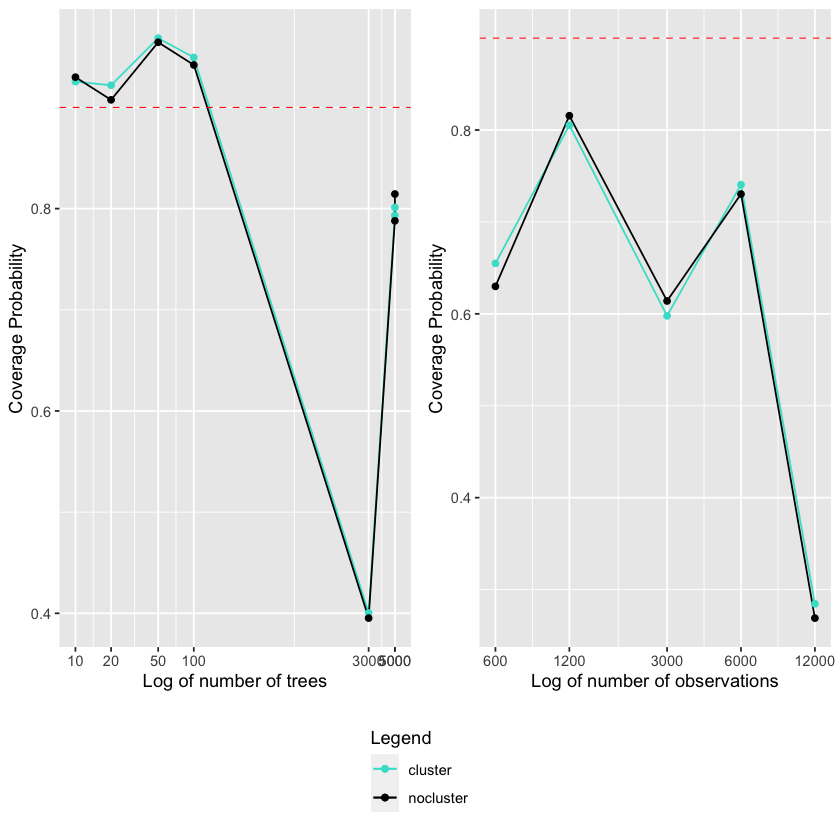

In [12]:
plot_coverage_function(n_test=12000, trees=c(10, 20, 50, 100, 5000, 3000, 5000), observations=c(600, 1200, 3000, 6000, 12000))

_Note: The plots show coverage probabilites varying over the number of trees (left) and the number of training observations (right) for cluster-robust and non-cluster robust honest forests together with the target coverage of 90 percent (red dashed line). Coverage probabilities are calculated using 12000 test observations. In the left plot 6000 training observations were used. In the right plot 4000 trees were grown. The horizontal axis is displayed on log scale for both plots._

### 3.4 Model Misspecification and the Value of Nonparametric Estimation

Figure 1 attempts to display a typical situation a researcher mind find herself in who suspects heterogeneity in treatment effects along two dimensions, in this case the total budget of the village and the salary of the village head. She may estimate the misspecified medium complexity model including simple interactions and interactions between the treatment and the squares of the total budget and the village head salary. The true data generating process, however, might be given by the medium complexity model that, beyond the simple interactions, includes a triple interaction and an interaction between treatment and the square of village head salary. As figure 1 shows, if the researcher estimates the correctly specified model, the estimated treatment effect function $\hat{\tau}(x)_{linear, \, true}$ provides a better fit to the true treatment effect function $\tau(x)$ than the honest causal forest does. In particular, the increase in the treatment effect for large salaries and large budgets is more accurately captured in the correctly specified linear model. The estimated treatment effect function using the causal forest $\hat{\tau}(x)_{honest \, CF}$ performs better than the misspecified linear model in characterizing the true treatment effect function. This illustrates one advantage of using causal forests over estimating parametric models: the causal forest does not impose specific functional forms and the researcher can thus hope to obtain fairly accurate estimates of conditional average treatment effects even without knowing the true data generating process.

---

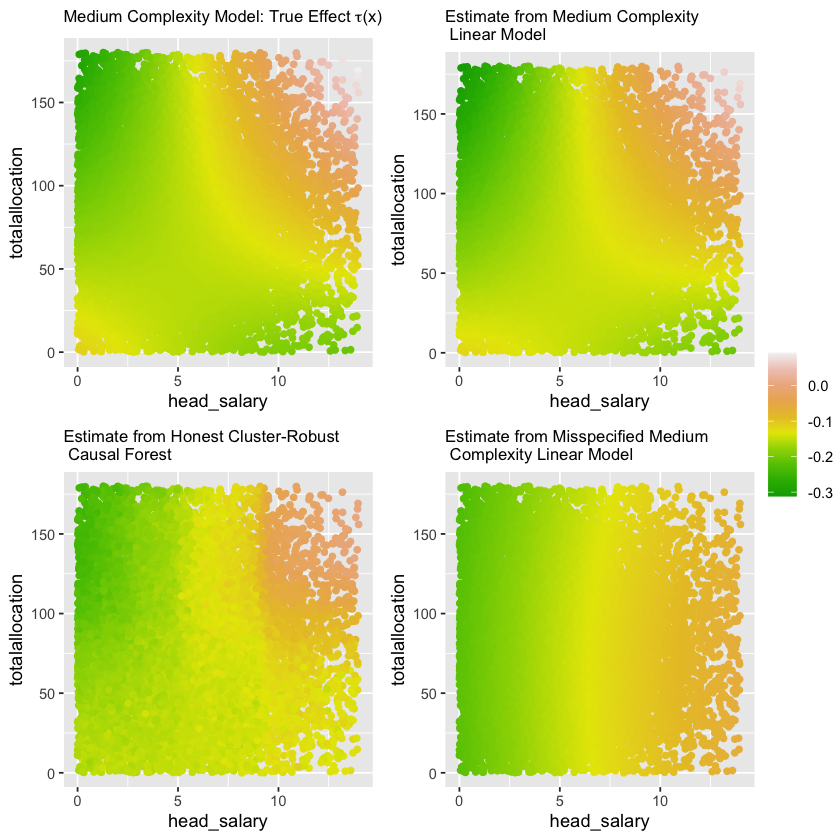

In [13]:
figure1(n_test=12000, n_train=12000, n.trees=2000, model='medium', N_clusters=150)

_Note: The plots show the true treatment effect $\tau(X_i)$ (upper left), the medium complexity linear model estimate $\hat{\tau}(X_i)_{linear,\, true}$ (upper right), the honest causal forest estimate $\hat{\tau}(X_i)_{honest \, CF}$ (lower left) and the misspecified medium complexity linear model estimate $\hat{\tau}(X_i)_{linear,\, misspecified}$ (lower left) for 11342 test observations $X_i$. The test observations were restricted to have head_salary less than 14 and totalallocation less than 180. This removes outliers and allows to visualize the granularity of the difference in the treatment effect functions._

---

#### 4. Empirical Application

In [14]:
In this section, the causal forest algorithm is applied to the empirical data used by Olken (2007). 

ERROR: Error in parse(text = x, srcfile = src): <text>:1:4: unerwartetes Symbol
1: In this
       ^


In [ ]:
rbinom(2,10,0.5)

cf<-causal_forest(X, merged_data$lndiffeall4mainancil, merged_data$audit.x, clusters=merged_data$desaid, min.node.size=30)
?causal_forest
cf
tau.hat = predict(cf)$predictions
tau.hat
ATE = average_treatment_effect(cf)
ATE
paste("95% CI for the ATE:", round(ATE[1], 3),
      "+/-", round(qnorm(0.975) * ATE[2], 3))
a<-round(merged_data$totalallocation/50)*50
dev.off()
options(device = "RStudioGD")
boxplot(tau.hat ~ merged_data$podeszhill, xlab = "X1", ylab = "estimated CATE")
boxplot(tau.hat ~ round(merged_data$zpercentpoorpra), xlab = "X1", ylab = "estimated CATE")
boxplot(tau.hat ~ round(merged_data$zpop), xlab = "X1", ylab = "estimated CATE")
boxplot(tau.hat ~ a, xlab = "X1", ylab = "estimated CATE")
boxplot(tau.hat ~ merged_data$zkadesedyears, xlab = "X1", ylab = "estimated CATE")

# Variables

Y: Major items in roads and ancilliary projects

W: Audit Treatment (increasing probability of external government audit from 4 to 100 percent)

X1: Village Population (in 1,000)
X2: Mosques per 1,000 population
X3: Total budget (in rp. million)
X4: Number subprojects
X5: Percent household poor
X6: Distance to subdistrict
X7: Village head education
X8: Village head salary (hectares)
X9: Mountainous dummy

In [ ]:
install.packages("truncnorm")
library(truncnorm)

In [ ]:
as.list(enumerate(rnorm(5)))

In [ ]:
X<-rtmvnorm(n=100, mean = rep(0, 3), sigma = diag(3), lower=rep(-Inf, length = 3), upper=rep(Inf, length = 3))

In [ ]:
X

In [ ]:
merged_data<-merge(randomization_data, road_data, by="desaid")

merged_data<-merged_data[!is.na(merged_data$lndiffeall4mainancil),]
merged_data$desaid<-as.numeric(merged_data$desaid)
X=cbind(merged_data$zpop, merged_data$totalmesjid, merged_data$totalallocation, merged_data$z4RABnumsubproj, merged_data$zpercentpoorpra, merged_data$zdistancekec,
        merged_data$zkadesedyears, merged_data$zkadesage, merged_data$zkadesbengkoktotal, merged_data$podeszhill)
cf<-causal_forest(X, merged_data$lndiffeall4mainancil, merged_data$audit.x, clusters=merged_data$desaid, min.node.size=30)


tau.hat = predict(cf)$predictions


#paste("95% CI for the ATE:", round(ATE[1], 3),
#      "+/-", round(qnorm(0.975) * ATE[2], 3))
a<-round(merged_data$totalallocation/50)*50
indep_vars<-c("zpop", "totalmesjid", "totalallocation", "z4RABnumsubproj", "zpercentpoorpra",
              "zdistancekec", "zkadesedyears", "zkadesage", "zkadesbengkoktotal")



ols<-lm(lndiffeall4mainancil~zpop+audit.x*totalallocation+audit.x*z4RABnumsubproj+audit.x*zpercentpoorpra+audit.x*zdistancekec+audit.x*zkadesedyears+audit.x*zkadesbengkoktotal, data=merged_data)
coeftest(ols, vcov.=vcovHC(ols, cluster="kecnum"))

In [ ]:
cf_empirical_function<-function(dataset1, dataset2){

merged_data<-merge(dataset1, dataset2, by="desaid")
merged_data<-merged_data[!is.na(merged_data$lndiffeall4mainancil),]
merged_data$desaid<-as.numeric(merged_data$desaid)

merged_data<-as.data.frame(merged_data)

merged_data<-rename(merged_data, c("zdistancekec"="distance", "zkadesedyears"="head_education_years", "zpop"="population",
                     "zpercentpoorpra"="percentage_poor", "zkadesbengkoktotal"="head_salary", "zkadesage"="head_age",
                      "podeszhill"="mountainous", "totalmesjid"="mosques", "audit.x"="audit", "kecnum.x"="subdistrict", 
                     "lndiffeall4mainancil"="ln_diff_items", "z4RABnumsubproj"="subprojects"))
covariates<-c('distance', 'head_education_years', 'population', 'percentage_poor', 'head_salary',
              'head_age', 'mountainous', 'mosques', 'subprojects')

X=merged_data[,covariates]
cf_honest_clustered<-causal_forest(X=X, Y=merged_data$ln_diff_items, W=merged_data$audit, clusters=merged_data$subdistricts)
cf_honest_not_clustered<-causal_forest(X=X, Y=merged_data$ln_diff_items, W=merged_data$audit)
cf_adaptive<-causal_forest(X=X, Y=merged_data$ln_diff_items, W=merged_data$audit, honesty=FALSE)
    
variable_importance_honest_clustered=variable_importance(cf_honest_clustered)
variable_importance_adaptive=variable_importance(cf_adaptive)
#tau_hat_clustered = predict(cf_clustered)$predictions
#hist(tau_hat_clustered)
#tau_hat_not_clustered = predict(cf_not_clustered)$predictions
#hist(tau_hat_not_clustered)

#sd(tau_hat_clustered)
#sd(tau_hat_not_clustered)

ATE_honest_clustered<-average_treatment_effect(cf_honest_clustered)
ATE_honest_not_clustered<-average_treatment_effect(cf_honest_not_clustered)
ATE_adaptive<-average_treatment_effect(cf_adaptive)

tauhat_honest_clustered<-predict(cf_honest_clustered)$predictions
tauhat_honest_not_clustered<-predict(cf_honest_not_clustered)$predictions
tauhat_adaptive<-predict(cf_adaptive)$predictions

return(list(ATE_honest_clustered=ATE_honest_clustered, ATE_honest_not_clustered=ATE_honest_not_clustered,
            ATE_adaptive=ATE_adaptive, tauhat_honest_clustered=tauhat_honest_clustered, 
           tauhat_honest_not_clustered=tauhat_honest_not_clustered, 
           tauhat_adaptive=tauhat_adaptive, cf_honest_clustered=cf_honest_clustered, 
           cf_honest_not_clustered=cf_honest_not_clustered, cf_adaptive=cf_adaptive, X=X, 
           merged_data=merged_data, 
           variable_importance_honest_clustered=variable_importance_honest_clustered,
           variable_importance_adaptive=variable_importance_adaptive))
}

In [ ]:
ATE_function<-function(dataset1, dataset2){
empirical_results<-cf_empirical_function(randomization_data, road_data)
df<-data.frame()

df['ATE','Honest cluster-robust CF']<-empirical_results$ATE_honest_clustered[1]
df['Standard Error','Honest cluster-robust CF']<-empirical_results$ATE_honest_clustered[2]
df['ATE','Honest non-cluster-robust CF']<-empirical_results$ATE_honest_not_clustered[1]
df['Standard Error','Honest non-cluster-robust CF']<-empirical_results$ATE_honest_not_clustered[2]
df['ATE', 'Adaptive non-cluster-robust CF']<-empirical_results$ATE_adaptive[1]
df['Standard Error', 'Adaptive non-cluster-robust CF']<-empirical_results$ATE_adaptive[2]
    
    return(df)
}

In [ ]:
ATE_function(randomization_data, road_data)

In [ ]:
cf_empirical_function(randomization_data, road_data)['cf_honest_clustered']

In [ ]:
CATE_plot_function<-function(dataset1, dataset2){
    empirical_results<-cf_empirical_function(dataset1, dataset2)

tauhat_df<-data.frame()
p<-list()

for (i in c('tauhat_honest_clustered', 'tauhat_honest_not_clustered', 'tauhat_adaptive')){


tauhat<-as.data.frame(empirical_results[i])
#tauhat_df<-cbind(tauhat_df, tauhat)
p[[i]]<-ggplot(tauhat, aes_string(x=tauhat[,i])) + 
    geom_histogram()
}


do.call(grid.arrange, p)
}

In [ ]:
CATE_plot_function(randomization_data, road_data)

In [ ]:
cf<-cf_empirical_function(randomization_data, road_data)[i]

variable_importance(cf)
important_variables=which(variable_importance > mean(variable_importance))
important_variables


cf_imp<-causal_forest(X=X[,important_variables], Y=merged_data$ln_diff_items, W=merged_data$audit, clusters=merged_data$subdistricts, tune.parameters="all")
#cf_n_imp<-causal_forest(X=X[,important_variables], Y=merged_data$ln_diff_items, W=merged_data$audit, tune.parameters="all")
tau_hat_clustered = predict(cf_imp)$predictions
#plot_df<-as.data.frame(cbind(X, tau_hat_clustered))
#hist(tau_hat_clustered)
#tau_hat_not_clustered = predict(cf_n_imp)$predictions
#hist(tau_hat_not_clustered)

#sd(tau_hat_clustered)
#sd(tau_hat_not_clustered)

#average_treatment_effect(cf_imp)
#average_treatment_effect(cf_n_imp)

#test_calibration(cf_imp)
#test_calibration(cf_n_imp)

audit.x:zpop=-0.013 not sig
audit.x:totalallocation  0.00129030 sig 5
audit.x:zpercentpoorpra -0.1284986 not sig
audit.x:zkadesbengkoktotal -0.0085617 not sig

zkadesage          -0.00342802
zkadesedyears      -0.00570659
totalallocation     0.00067749
totalmesjid        -0.03397987
z4RABnumsubproj    -0.02843929 

In [ ]:
merged_data<-merge(randomization_data, road_data, by="desaid")
merged_data<-merged_data[!is.na(merged_data$lndiffeall4mainancil),]
merged_data$desaid<-as.numeric(merged_data$desaid)

merged_data<-as.data.frame(merged_data)

merged_data<-rename(merged_data, c("zdistancekec"="distance", "zkadesedyears"="head_education_years", "zpop"="population",
                     "zpercentpoorpra"="percentage_poor", "zkadesbengkoktotal"="head_salary", "zkadesage"="head_age",
                      "podeszhill"="mountainous", "totalmesjid"="mosques", "audit.x"="audit", "kecnum.x"="subdistrict", 
                     "lndiffeall4mainancil"="ln_diff_items", "z4RABnumsubproj"="subprojects"))
covariates<-c('distance', 'head_education_years', 'population', 'percentage_poor', 'head_salary',
              'head_age', 'mountainous', 'mosques', 'subprojects')
X=merged_data[, covariates]
cf_clustered<-causal_forest(X=X, Y=merged_data$ln_diff_items, W=merged_data$audit, clusters=merged_data$subdistricts, tune.parameters="all")
#variable_importance(cf_clustered)

In [ ]:
variable_importance=variable_importance(cf_clustered)
important_variables=which(variable_importance > mean(variable_importance))
important_variables


cf_imp<-causal_forest(X=X[,important_variables], Y=merged_data$ln_diff_items, W=merged_data$audit, clusters=merged_data$subdistricts, tune.parameters="all")
#cf_n_imp<-causal_forest(X=X[,important_variables], Y=merged_data$ln_diff_items, W=merged_data$audit, tune.parameters="all")
tau_hat_clustered = predict(cf_imp)$predictions
#plot_df<-as.data.frame(cbind(X, tau_hat_clustered))
#hist(tau_hat_clustered)
#tau_hat_not_clustered = predict(cf_n_imp)$predictions
#hist(tau_hat_not_clustered)

#sd(tau_hat_clustered)
#sd(tau_hat_not_clustered)

#average_treatment_effect(cf_imp)
#average_treatment_effect(cf_n_imp)

#test_calibration(cf_imp)
#test_calibration(cf_n_imp)

In [ ]:
install.packages("gridExtra")
library(gridExtra)

In [ ]:
boxplots<-function(forest, variable_importance){
empirical_results=cf_empirical_function(randomization_data, road_data)
cf=empirical_results[forest]
X=empirical_results$X
merged_data=empirical_results$merged_data
variable_importance=unlist(empirical_results[variable_importance], use.names=FALSE)
important_variables=which(variable_importance > mean(variable_importance))

if (forest=='cf_honest_clustered'){

cf_imp<-causal_forest(X=X[,important_variables], Y=merged_data$ln_diff_items,
                      W=merged_data$audit, clusters=merged_data$subdistricts)
    }

if (forest=='cf_adaptive'){

cf_imp<-causal_forest(X=X[,important_variables], Y=merged_data$ln_diff_items,
                      W=merged_data$audit, tune.parameters="all")
    }

tau_hat_clustered<-predict(cf_imp)$predictions

plot_data<-as.data.frame(cbind(X[,important_variables], tau_hat_clustered))
names<-names(plot_data[,-(ncol(plot_data))])
names
p<-list()
for (i in index(names)){
    name<-names[i]
    p[[i]]<-ggplot(plot_data, aes_string(x=plot_data[,name], y=tau_hat_clustered)) + 
          geom_boxplot(aes(group = cut_width(plot_data[,name], ((min(plot_data[,name]))+(max(plot_data[,name])))/10)))+
            geom_smooth()
    }
do.call(grid.arrange, c(p, ncol=2))
    }

In [ ]:
boxplots(forest='cf_adaptive', variable_importance='variable_importance_adaptive')

In [ ]:
boxplots(forest='cf_honest_clustered', variable_importance='variable_importance_honest_clustered')

In [ ]:
empirical_results=cf_empirical_function(randomization_data, road_data)
cf=empirical_results['cf_adaptive']
X=empirical_results$X
merged_data=empirical_results['merged_data']
variable_importance=unlist(empirical_results['variable_importance_adaptive'], use.names=FALSE)
important_variables=which(variable_importance > mean(variable_importance))
variable_importance
important_variables
X

In [ ]:
mean(variable_importance)

In [ ]:
important_variables

In [ ]:
p<-ggplot(plot_data, aes(x=plot_data[,'mountainous'], y=tau_hat_clustered)) + 
      geom_boxplot(aes(group = cut_width(plot_data[,'mountainous'], ((min(plot_data[,'mountainous']))+(max(plot_data[,'mountainous'])))/10)))
    p

In [ ]:
for (i in names(X)){
    
    boxplot(tau_hat_clustered ~ round(merged_data[,i]), 
            xlab = i, ylab = "estimated CATE")
}

In [ ]:
round(plot_data$mosques)

In [ ]:
boxplot(tau_clustered ~ round(merged_data$mountainous, xlab = "Mountainous", ylab = "estimated CATE")
boxplot(tau.hat ~ round(merged_data$zpercentpoorpra), xlab = "X1", ylab = "estimated CATE")
boxplot(tau.hat ~ round(merged_data$zpop), xlab = "X1", ylab = "estimated CATE")
boxplot(tau.hat ~ a, xlab = "X1", ylab = "estimated CATE")
boxplot(tau.hat ~ merged_data$zkadesedyears, xlab = "X1", ylab = "estimated CATE")

Questions:

DGP heuristically or actually calculate means, standard deviations, correlations, correlations within subdistricts?
Truncated normal?

Use probit model to predict whether mountainous or not?

Changing number of trees and sample size to vary honest and adaptive?

In [ ]:
lower=c(1,2,3)
upper=c(10,11, 12)
this=c(12,6,9)
sum(lower<=this&this<=upper)

In [ ]:
X_train=matrix(nrow=900, ncol=10, rnorm(10, 1))
X_test=matrix(nrow=900, ncol=10, rnorm(10, 1))
W=rbinom(900, 1, p=0.5)
tau=0.1*X_train[,1]
Y=tau+rnorm(n=900, 0, 1)
cf_honest<-causal_forest(W=W, X=X_train, Y=Y)
cf_adaptive<-causal_forest(W=W, X=X_train, Y=Y, honesty=FALSE)
honest<-predict(X=X_test, cf_honest, estimate.variance=TRUE)
tauhat_honest<-honest$predictions
var_honest<-honest$variance.estimates

adaptive<-predict(X=X_test, cf_adaptive, estimate.variance=TRUE)
tauhat_adaptive<-adaptive$predictions
var_adaptive<-adaptive$variance.estimates

#predict(cf, X_test, estimate.variance=TRUE)$variance.estimates


In [ ]:
(mse_hon<-mean((tauhat_honest-tau)^2))
(mse_ada<-mean((tauhat_adaptive-tau)^2))

mean(tauhat_honest-2*sqrt(var_honest)<=tau&tau<=tauhat_honest+2*sqrt(var_honest))
mean(tauhat_adaptive-2*sqrt(var_adaptive)<=tau&tau<=tauhat_adaptive+2*sqrt(var_adaptive))

In [ ]:
c(a,b)<-c(1,2)

To do so, we use the infinitesimal jackknife for random forests developed by Efron (2014) and Wager, Hastie, and Efron (2014), based on the original infinitesimal jackknife procedure of Jaeckel (1972). This method assumes that we have taken the number of trees B to be large enough that the Monte Carlo variability of the forest does not matter; and only measures the randomness in τˆ(x) due to the training sample.

## References

**Abadie, A., Athey, S., Imbens, G.W. and Wooldridge, J. (2017).** When Should You Adjust Standard Errors for Clustering? National Bureau of Economic Research,  Working Paper No. 24003.

**Athey, S. (2018).** Machine learning for heterogeneous treatment effects and personalized policy
estimation. University of California, Davis. The University of California Lecture.

**Athey, S. Tibshirani, J. and Wager, S. (2019).** Generalized Random Forests. Annals of Statistics 47 (2), 1148-1178.

**Athey, S. and Wager, S. (2019).** Estimating Treatment Effects with Causal Forests: An Application. arXiv preprint arXiv:1902.07409.

**Davis, J.M.V., and Heller, S.B. (2017).** Online Appendix to Using Causal Forests to Predict Treatment Heterogeneity: An Application to Summer Jobs. American Economic Review 107 (5), 546-50. Available at https://www.aeaweb.org/content/file?id=4234.

**Wager, S. and Athey, S. (2018).** Estimation and Inference of Heterogeneous Treatment Effects using Random Forests. Journal of the American Statistical Association 113(523), 1228-1242.

In [ ]:
N_total<-60
N_clusters<-15
mean_cluster_size<-N_total/N_clusters

vector<-rep((mean_cluster_size-(1/4)*mean_cluster_size):(mean_cluster_size+(1/4)*mean_cluster_size), times=N_clusters/3)
vector
rep(1:N_clusters, times=c(vector))

rep(c(1,2,3), times=3)

In [ ]:
covariance_matrix<-matrix(0, nrow=6000, ncol=6000)

In [ ]:
#a<-data.frame(this=rep(0,20))
#a
rmvnorm(mean=rep(0, 2000), sigma=covariance_matrix, n=1)

In [ ]:
i<-10
((i-5):(i+5))

In [ ]:
b<-1:5

In [ ]:
b[5]==1